# CPU time analysis

## Setup

In [1]:
import re
import datetime
from math import log
import csv
import pprint
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

from __future__ import division

%matplotlib inline

pp = pprint.PrettyPrinter()

## Open connection to ES

In [2]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

## List all jobs\_archive\_* indices

In [3]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

## Function to list all jobs\_archive\_* indices in the last N days

In [4]:
def time_filter(indices, days=0, until=0):
    if days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        try:
            day = datetime.datetime.strptime(day, datefmt).date()
            diff = today - day
            if until <= diff.days < days + until:
                filtered.append(i.rstrip())
        except:
            continue
    return filtered

## Group by (processingtype, transformation) and plot distribution of average CPU time/event by jeditaskid

In [5]:
# Change second argument to use a different time range for ES queries
ind = time_filter(indices, 0, 0)
ind = ','.join(ind)
ind

'jobs_archive_*'

I select only jobs with at least one event, successful, with a core count of at least one and that ran for at least 60 seconds.

I exclude test and analysis jobs.

I aggregate jobs by _processingtype_, _transformation_, _atlasrelease_, _computingsite_ and _jeditaskdid_.
In practice, all jobs in a task have the same value of all these variables save for the site, so each bucket corresponds to a combination of (_jeditaskid_, _computingsite_).

I record these quantities:

* Average of CPU time per event
* Average of wall-clock time per event
* Total CPU time
* Total wall-clock time (that is, multiplied by the number of cores)
* Average of core count
* Total number of events
* Average of CPU time divided by wall-clock time

Already at this level there's a theoretical flaw: averages of time and efficiency are done from the values of each individual job, disregarding the number of events in the job. The averages are correct only if all jobs in a task process the same number of jobs. **This is not strictly the case, but usually all jobs in a task have at least very similar numbers of events**.

In [8]:
s = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "must": [
                        {
                            "range": {
                                "nevents": {"gte": 1}
                            }
                        },
                        {
                            "range": {
                                "corecount": {"gte": 0}
                            }
                        },
                        {
                            "range": {
                                "wall_time": {"gt": 1, "lt": 2590000}
                            }
                        },
                        { 
                            "query": {
                                "wildcard": {
                                    "destinationdblock": "hc_test*tid601*"
                                }
                            }
                        },
                        {
                            "match": {
                                "jobstatus": "finished"
                            }
                        }
                    ],
                    "must_not": [
                        {
                            "query": {
                                "match": {
                                    "computingsite": "BOINC"
                                }
                            }
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "ptypes": {
            "terms": {
                "field": "processingtype",
                "size": 1000
            },
            "aggs": {
                "transf": {
                    "terms": {
                        "field": "transformation",
                        "size": 1000
                    },
                    "aggs": {
                        "atlrel": {
                            "terms": {
                                "field": "atlasrelease",
                                "size": 1000
                            },
                            "aggs": {
                                "site": {
                                    "terms": {
                                        "field": "computingsite",
                                        "size": 1000
                                    },
                                    "aggs": {
                                        "cputype": {
                                            "terms": {
                                                "field": "cpuconsumptionunit",
                                                "size": 1000
                                            },
                                            "aggs": {
                                                "1": {
                                                    "extended_stats": {
                                                        "script": "(doc['nevents'].value) ? doc['cpuconsumptiontime'].value/doc['nevents'].value : 0",
                                                        "lang": "expression"
                                                    }
                                                },
                                                "2": {
                                                    "extended_stats": {
                                                        "script": "(doc['nevents'].value) ? doc['wall_time'].value / doc['nevents'].value : 0",
                                                        "lang": "expression"
                                                    }
                                                },
                                                "3": {
                                                    "sum": {
                                                        "field": "cpuconsumptiontime"
                                                    }
                                                },
                                                "4": {
                                                    "sum": {
                                                        "field": "wall_time",
                                                    }
                                                },
                                                "6": {
                                                    "avg": {
                                                        "field": "corecount"
                                                    }
                                                },
                                                "7": {
                                                    "sum": {
                                                        "field": "nevents"
                                                    }
                                                },
                                                "8": {
                                                    "avg": {
                                                        "script": "doc['cpuconsumptiontime'].value/doc['wall_time'].value",
                                                        "lang": "expression"
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}
res = es.search(index=ind, body=s, request_timeout=12000)

## Write data to a CSV file

In [9]:
output_file = 'task_cpu_hcx.csv'

In [10]:
with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    buckets1 = res['aggregations']['ptypes']['buckets']
    for b1 in buckets1:
        ptype = b1['key']
        buckets2 = b1['transf']['buckets']
        for b2 in buckets2:
            transf = b2['key']
            buckets3 = b2['atlrel']['buckets']
            for b3 in buckets3:
                atlrel = b3['key']
                buckets4 = b3['site']['buckets']
                for b4 in buckets4:
                    site = b4['key']
                    buckets5 = b4['cputype']['buckets']
                    for b5 in buckets5:
                        cputype = b5['key']
                        writer.writerow([
                            ptype,
                            transf,
                            atlrel,
                            site,
                            cputype,
                            b5['1']['count'],
                            b5['1']['avg'],
                            b5['1']['std_deviation'],
                            b5['2']['avg'],
                            b5['2']['std_deviation'],
                            b5['3']['value'],
                            b5['4']['value'],
                            b5['6']['value'],
                            b5['7']['value'],
                            b5['8']['value']
                            ])

## Import to a DataFrame

In [11]:
input_file = 'task_cpu_hcx.csv'

In [12]:
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, names=['processingtype', 'transformation', 'atlrel', 'site',
                                                               'cputype', 'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                                                               'wallevt_rms', 'cpu', 'wc', 'cores', 'jevts', 'eff'])

In [11]:
df[:10]

,processingtype,transformation,atlrel,site,cputype,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cores,jevts,eff
0,gangarobot-pft,AtlasG4_trf.py,Atlas-17.2.2,DESY-ZN,s+Intel(R) Xeon(R) CPU E5-2640 v3 @ 2.60GHz 20...,282,177.241135,8.949358,187.973050,9.838143,499820,530084,0,2820,0.943102
1,gangarobot-pft,AtlasG4_trf.py,Atlas-17.2.2,DESY-ZN,s+Intel(R) Xeon(R) CPU E5-2660 0 @ 2.20GHz 204...,162,258.916667,10.021097,270.900617,11.186900,419445,438859,0,1620,0.955938
2,gangarobot-pft,AtlasG4_trf.py,Atlas-17.2.2,DESY-ZN,s+Intel(R) Xeon(R) CPU X5675 @ 3.07...,150,230.162000,7.847332,240.606000,9.054201,345243,360909,0,1500,0.956818
3,gangarobot-pft,AtlasG4_trf.py,Atlas-17.2.2,DESY-ZN,s+Intel(R) Xeon(R) CPU E5520 @ 2.27...,73,308.036986,7.815115,324.498630,9.931526,224867,236884,0,730,0.949508
4,gangarobot-pft,AtlasG4_trf.py,Atlas-17.2.2,DESY-ZN,s+Intel(R) Xeon(R) CPU X5660 @ 2.80...,49,250.008163,11.567986,260.695918,12.123042,122504,127741,0,490,0.959038
5,gangarobot-pft,AtlasG4_trf.py,Atlas-17.2.2,BNL_ATLAS_2,s+Intel(R) Xeon(R) CPU E5-2660 v3 @ 2.60GHz 25...,196,187.875510,11.865824,209.156633,17.532664,368236,409947,0,1960,0.901316
6,gangarobot-pft,AtlasG4_trf.py,Atlas-17.2.2,BNL_ATLAS_2,s+Intel(R) Xeon(R) CPU X5660 @ 2.80...,163,295.100000,18.602797,316.298773,28.671306,481013,515567,0,1630,0.935727
7,gangarobot-pft,AtlasG4_trf.py,Atlas-17.2.2,BNL_ATLAS_2,s+Intel(R) Xeon(R) CPU E5-2660 v2 @ 2.20GHz 25...,125,283.424000,16.040700,303.938400,21.031096,354280,379923,0,1250,0.933812
8,gangarobot-pft,AtlasG4_trf.py,Atlas-17.2.2,BNL_ATLAS_2,s+Intel(R) Xeon(R) CPU E5-2660 0 @ 2.20GHz 204...,115,282.077391,19.553877,306.020870,24.819657,324389,351924,0,1150,0.923762
9,gangarobot-pft,AtlasG4_trf.py,Atlas-17.2.2,BNL_ATLAS_2,s+Intel(R) Xeon(R) CPU X5650 @ 2.67...,114,307.692105,17.254825,326.822807,21.067411,350769,372578,0,1140,0.942191


Grouping by _processingtype_ and _transformation_ to calculate e.g. the average CPU time per event for each combination has a problem: one cannot simply average the values in the same group because this does not take into account the fact that different values have different statistical weights. So, one must use as weights the number of events in each bucket.
Unfortunately pandas does not have a simple way to do it for more than one quantity.

## Averages of wall-clock times

In [13]:
# Define aggregation
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

# Define function to average a given quantity using the number of events es weight
def weighted_avg(group, a, w):
    return np.average(group[a], weights=group[w])

# Calculate Series with the correctly averaged CPU time per event
a = grouped.apply(weighted_avg,'wallevt_avg', 'wc')
a

processingtype  transformation
gangarobot-pft  AtlasG4_trf.py    372.789838
dtype: float64

## Some statistics

The following is the list of (processingtype, transformation) combinations with some statistics.
Rows are sorted by decreasing wall-clock time.

In [14]:
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)
a = grouped.agg({
                 'cpuevt_avg' : 'mean',   # wrong!
                 'wallevt_avg': 'mean',   # wrong!
                 'wc': 'sum',             # ok!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                 'jevts': 'sum'})         # ok!
a.sort_values('wc', ascending=False)

,processingtype,transformation,wc,cpuevt_avg,jevts,cores,wallevt_avg,njobs
0,gangarobot-pft,AtlasG4_trf.py,148807636.0,331.289397,429700.0,0.0,357.613957,42970


## Events per task

## Distribution of efficiency

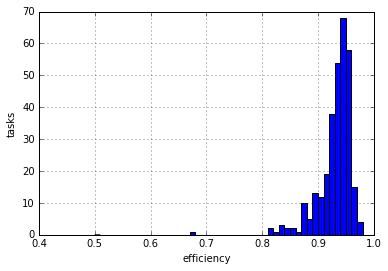

In [15]:
fig = df['eff'].hist(bins=50, log=False, range=(0.5, 1.))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('efficiency')
plt.ylabel('tasks')

In the plot above, note the existence of efficiencies larger than 1! This has to be understood.

## Plot distribution of averages of CPU time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average CPU time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average CPU time per event.
Combinations consisting of merge jobs, of that account for less than 1.5% of the total wall-clock time, are ignored.

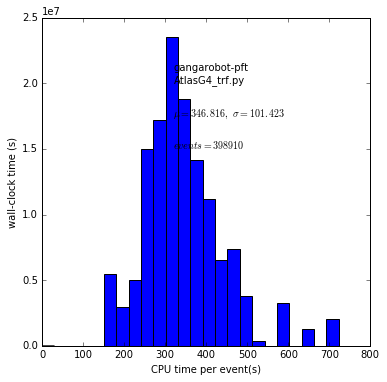

In [15]:
fig = plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 10})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., min(mean + std * 4., 10000.)]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=25, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('CPU time per event(s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['jevts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p+'\n'+t)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p+'\n'+t)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

## Plot distribution of averages of wallclock time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average wallclock time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average wallclock time per event.

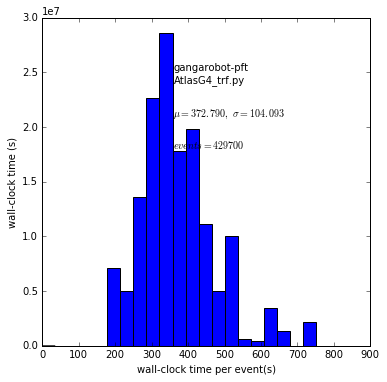

In [16]:
fig = plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 10})
var = 'wallevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., min(mean + std * 5., 8000.)]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=25, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('wall-clock time per event(s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['jevts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p+'\n'+t)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p+'\n'+t)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

## Plot distribution of averages of CPU efficiency per event for tasks grouped by processingtype and transformation

Total wall-clock: 1.48808e+08 s
Total wall-clock of evgen: 0 s
Total wall-clock of evgen with low efficiency: 0 s


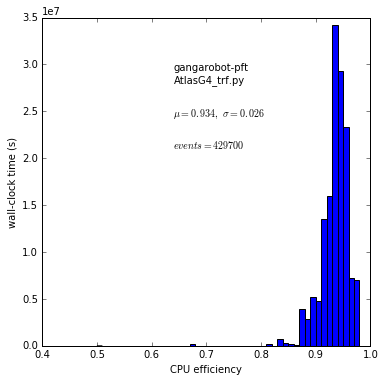

In [19]:
fig = plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size': 10})
var = 'eff'
wc_tot = df['wc'].sum()
print 'Total wall-clock: %g s' % wc_tot
print 'Total wall-clock of evgen: %g s' % df[df.processingtype == 'evgen']['wc'].sum()
print 'Total wall-clock of evgen with low efficiency: %g s' % df[(df.processingtype == 'evgen') & (df['eff'] <= .8)]['wc'].sum()

i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if i > 9: break
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0.5, 1.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=50, range=range, weights=g['wc'].tolist(), log=False)   # integral is total no. of events
    plt.xlabel('CPU efficiency')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(.4), t_y(.8), p+'\n'+t)
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    plt.text(t_x(.4), t_y(.7), stats)
    stats = r'$\mathit{events}=%g$' % g['jevts'].sum()
    plt.text(t_x(.4), t_y(.6), stats)
    i += 1